In [385]:
import os
import math
import warnings 
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt

from pmdarima.arima import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [386]:
#dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SOXL.csv'
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
#dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/MRNA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']


ts.head()

Date
2021-04-28    152.767502
2021-04-29    153.247498
2021-04-30    150.095001
2021-05-03    148.367493
2021-05-04    143.512497
Name: Close, dtype: float64

In [387]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [388]:
# 로그 변환 시도 
ts_log = np.log(ts)

In [389]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [390]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

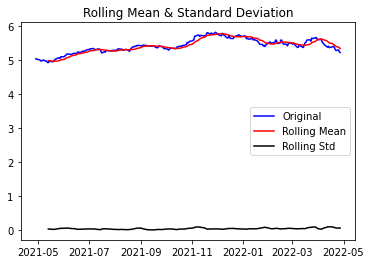

Results of Dickey-Fuller Test:
Test Statistic                  -1.722894
p-value                          0.419357
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


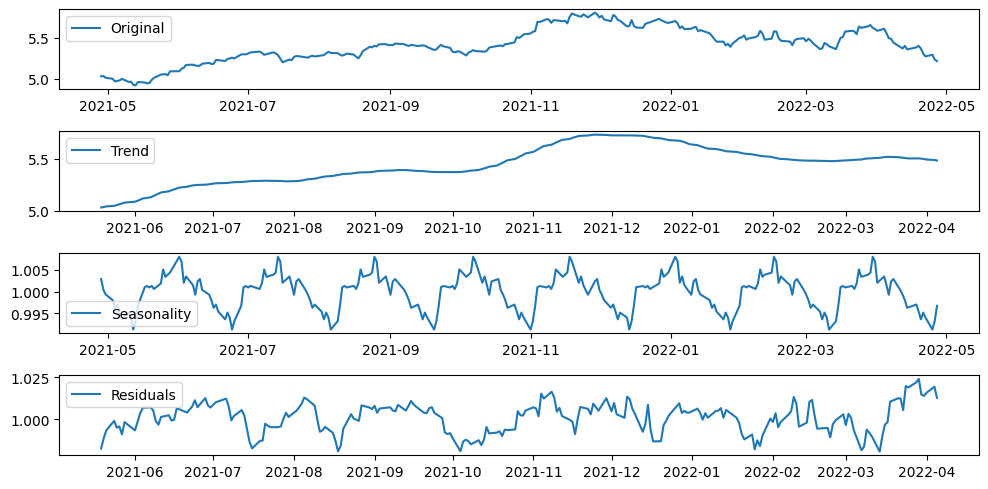

In [433]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,5), dpi=100)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [434]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.147068
p-value                          0.000011
#Lags Used                       7.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


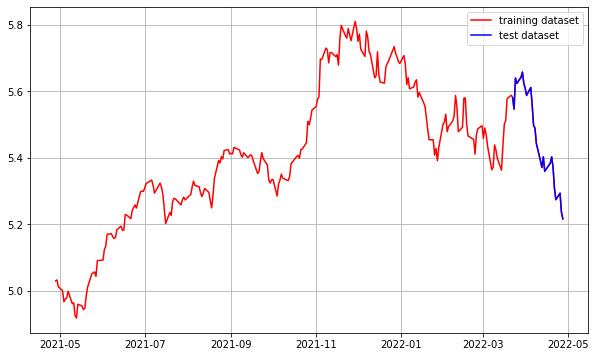

In [435]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [458]:
# ACF, PACF 그려보기 -> p,q 구하기

plt.figure(figsize=(10,5), dpi=100)
plot_acf(ts_log,lag.max = 20)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (549557488.py, line 4)

Results of Dickey-Fuller Test:
Test Statistic                -1.513481e+01
p-value                        7.147094e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.213225e+01
p-value                        1.725192e-22
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


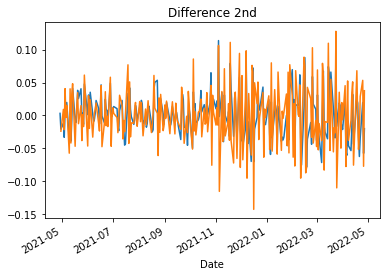

In [437]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [455]:
warnings.filterwarnings('ignore') #경고 무시

# Build Model
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 3, 2)   Log Likelihood                 448.593
Date:                Thu, 28 Apr 2022   AIC                           -887.186
Time:                        09:12:45   BIC                           -870.127
Sample:                             0   HQIC                          -880.300
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0034      0.073      0.047      0.963      -0.139       0.146
ar.L2         -0.1274      0.067     -1.893      0.058      -0.259       0.005
ma.L1         -1.9114      0.029    -64.925      0.0

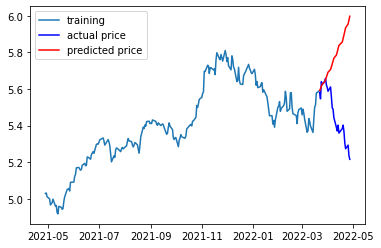

In [456]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha = 0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
#plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [457]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12366.195768911422
MAE:  85.98783244882144
RMSE:  111.20339818958512
MAPE: 40.83%


In [449]:
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [454]:
model = pm.auto_arima (train_data, d = 3,seasonal = True, trace = True)
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=-887.186, Time=0.73 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-531.696, Time=1.06 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-633.714, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=1.00 sec
 ARIMA(2,3,3)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(1,3,3)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(3,3,3)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(2,3,2)(0,0,0)[0] intercept   : AIC=-802.977, Time=0.99 sec

Best model:  ARIMA(2,3,2)(0,0,0)[0]          
Total fit time: 9.711 seconds


ARIMA(order=(2, 3, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)